In [1]:
import nomic
import json
api_key_path = "/home/ubuntu/api_keys.json"

with open(api_key_path, 'r') as j:
    key = json.loads(j.read())['nomic']

nomic.login(key)

from nomic import AtlasDataset
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
from fuzzywuzzy import fuzz

dataset = AtlasDataset('hivemind/tweets-from-members-of-us-congress-from-all-time-updated-2024-05-29')

embds = dataset.maps[0].embeddings.latent
df = dataset.maps[0].data.df

2024-06-07 20:51:54.374 | INFO     | nomic.dataset:__init__:829 - Loading existing dataset `hivemind/tweets-from-members-of-us-congress-from-all-time-updated-2024-05-29`.
100%|██████████████████████████████████████████████████████████████████████████████| 129/129 [00:00<00:00, 26574.91it/s]


In [3]:
congress_names, tweets_per_congress_person = np.unique(list(df['name']), return_counts=True)
congress_names = list(congress_names)
congress_handles = [list(df['twitter_lower'][df['name'] == cn])[0] for cn in congress_names]

average_embds = np.zeros((len(congress_names), embds.shape[1]))
party_by_congress_person = [-1 for cp in congress_names]

for i, embd in enumerate(tqdm(embds)):
    congress_name_index = congress_names.index(df['name'][i])
    average_embds[congress_name_index] += embd

    if party_by_congress_person[congress_name_index] == -1:
        party_by_congress_person[congress_name_index] = df['party'][i].lower()

average_embds = np.divide(average_embds, tweets_per_congress_person.reshape(-1, 1))
unique_party_labels, party_counts = np.unique(party_by_congress_person, return_counts=True)

100%|██████████████████████████████████████████████████████████████████████| 3037316/3037316 [01:51<00:00, 27274.05it/s]


/home/ubuntu/venvs/pnma/lib/python3.8/site-packages/graspologic/models/edge_swaps.py:215: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  _edge_swap_numba = nb.jit(_edge_swap, nopython=False)


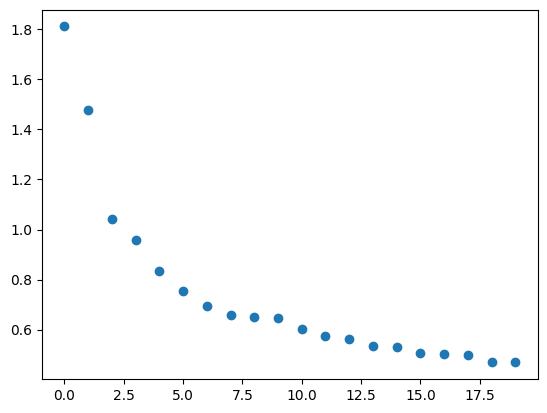

In [4]:
from graspologic.embed import ClassicalMDS
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

CMDS = ClassicalMDS(n_components=20)
cmds_embds = CMDS.fit_transform(average_embds)
singular_values = CMDS.singular_values_

CMDS = ClassicalMDS()
cmds_embds = CMDS.fit_transform(average_embds)

LDA = LinearDiscriminantAnalysis()
LDA.fit(cmds_embds, party_by_congress_person)
lda_embds = LDA.transform(cmds_embds)

colors = {
    'd': 'b',
    'r': 'r',
    'i': 'g'
         }

fig, ax = plt.subplots(1,1)
ax.scatter(range(len(singular_values)), singular_values)

Text(0.5, 1.05, 'Representations of Congressional Tweeters \nbased on average embedding of tweets')

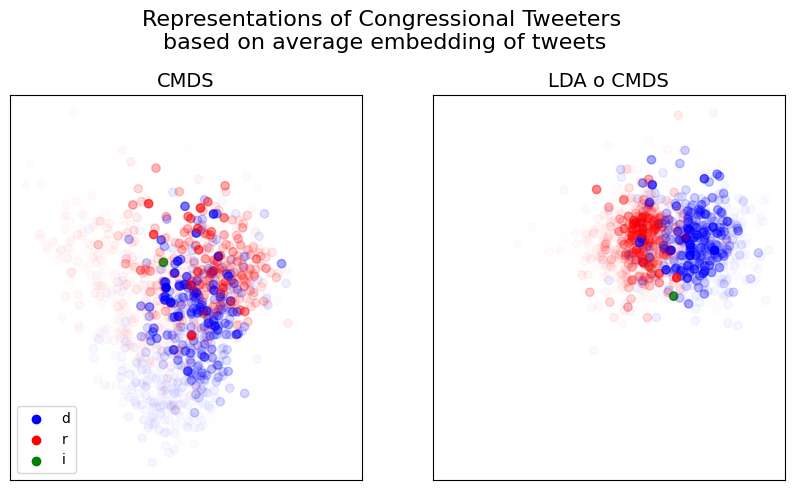

In [5]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
color_by_congress_person = [colors[p] for p in party_by_congress_person]
boldness_by_congress_person = tweets_per_congress_person / max(tweets_per_congress_person)

ax[0].scatter(cmds_embds[:, 0], cmds_embds[:, 1], 
              c=color_by_congress_person, 
              alpha=boldness_by_congress_person)
ax[0].set_title('CMDS', fontsize=14)
xlim, ylim = ax[0].get_xlim(), ax[0].get_ylim()

for label,color in colors.items():
    ax[0].scatter(1e5, 1e5, label=label, color=color)

ax[0].set_xlim(*xlim)
ax[0].set_ylim(*ylim)

ax[0].legend()

ax[1].scatter(lda_embds[:, 0], lda_embds[:, 1], c=color_by_congress_person, alpha=boldness_by_congress_person)
ax[1].set_title('LDA o CMDS', fontsize=14)

for ax_ in ax:
    ax_.set_yticks([])
    ax_.set_xticks([])

fig.suptitle('Representations of Congressional Tweeters \nbased on average embedding of tweets', fontsize=16, y=1.05)

In [55]:
df_vote_result = pd.read_csv('/home/ubuntu/df_vote_result.csv')
df_vote_result.drop(columns=['average_embd', 'congress_person_name'], inplace=True)

matched_name = []
average_embd = []
handles = []
party= []

for i, row in df_vote_result.iterrows():
    voter_name = row['Name']
    highest_ratio_index = np.argmax([fuzz.token_sort_ratio(voter_name, name) for name in congress_names])

    matched_name.append(congress_names[highest_ratio_index])
    average_embd.append(average_embds[highest_ratio_index])
    handles.append(congress_handles[highest_ratio_index])
    party.append(party_by_congress_person[highest_ratio_index])

df_vote_result['matched-name'] = matched_name
df_vote_result['twitter-handle'] = handles
df_vote_result['party'] = party
df_vote_result['average-embd'] = average_embd

In [56]:
df_vote_result.head()

,Name,Vote,matched-name,twitter-handle,party,average-embd
0,Alexander (R-TN),Yea,Lamar Alexander R-TN,senalexander,r,"[0.008917577819331087, 0.040894072102810715, -..."
1,Baldwin (D-WI),Nay,Tammy Baldwin D-WI,senatorbaldwin,d,"[0.005757182689581875, 0.04460483891951056, -0..."
2,Barrasso (R-WY),Yea,John Barrasso R-WY,senjohnbarrasso,r,"[0.007505987690244786, 0.05119599598564999, -0..."
3,Bennet (D-CO),Nay,Michael Bennet D-CO,senbennetco,d,"[0.017452976613833188, 0.04856638369018015, -0..."
4,Blumenthal (D-CT),Nay,"Blumenthal, Richard",senblumenthal,d,"[0.01480758892566668, 0.05020238554437554, -0...."


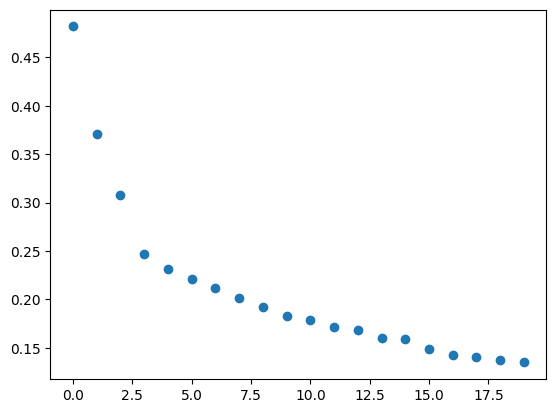

In [62]:
#- Now just looking at vote data

vote_embds = np.array(list(df_vote_result['average-embd']))

CMDS = ClassicalMDS(n_components=20)
cmds_embds = CMDS.fit_transform(vote_embds)
singular_values = CMDS.singular_values_

CMDS = ClassicalMDS()
cmds_embds = CMDS.fit_transform(vote_embds)

vote_by_congress_person = np.array(list(df_vote_result['Vote']))
vote_by_congress_person = [0 if v == ' Nay' else 1 for v in vote_by_congress_person]

LDA = LinearDiscriminantAnalysis()
LDA.fit(cmds_embds, vote_by_congress_person)
lda_embds = LDA.transform(cmds_embds)

vote_colors = {
    0: 'orange',
    1: 'purple',
    # 'i': 'g'
         }

party_colors = {
    'r': 'r',
    'd': 'b',
    'i': 'g'
         }

fig, ax = plt.subplots(1,1)
ax.scatter(range(len(singular_values)), singular_values)

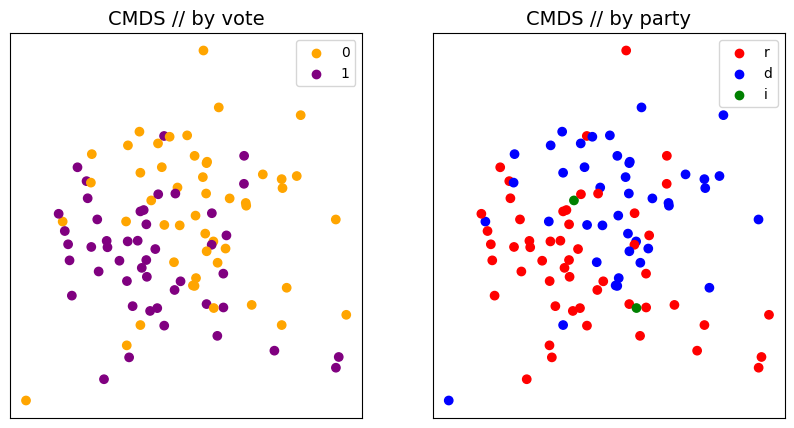

In [64]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
color_by_congress_person = [vote_colors[p] for p in vote_by_congress_person]
boldness_by_congress_person = tweets_per_congress_person / max(tweets_per_congress_person)

ax[0].scatter(cmds_embds[:, 0], cmds_embds[:, 1], 
              c=color_by_congress_person)
ax[0].set_title('CMDS // by vote', fontsize=14)
xlim, ylim = ax[0].get_xlim(), ax[0].get_ylim()

for label,color in vote_colors.items():
    ax[0].scatter(1e5, 1e5, label=label, color=color)

ax[0].set_xlim(*xlim)
ax[0].set_ylim(*ylim)

ax[0].legend()


color_by_congress_person = [party_colors[p] for p in df_vote_result['party']]
ax[1].scatter(cmds_embds[:, 0], cmds_embds[:, 1], 
              c=color_by_congress_person)
ax[1].set_title('CMDS // by party', fontsize=14)
xlim, ylim = ax[1].get_xlim(), ax[1].get_ylim()

for label,color in party_colors.items():
    ax[1].scatter(1e5, 1e5, label=label, color=color)

ax[1].set_xlim(*xlim)
ax[1].set_ylim(*ylim)

ax[1].legend()

# ax[1].scatter(lda_embds[:, 0], vote_by_congress_person)
# ax[1].set_title('LDA o CMDS', fontsize=14)

for ax_ in ax:
    ax_.set_yticks([])
    ax_.set_xticks([])

# fig.suptitle('Representations of Congressional Tweeters \nbased on average embedding of tweets', fontsize=16, y=1.05)